In [2]:
# =====================================================
# HÜCRE 1 – KÜTÜPHANELERİN YÜKLENMESİ 
# Bu hücrede veri işleme, model kurma ve görselleştirme için
# kullanılacak tüm Python kütüphaneleri içe aktarılır.
# Ayrıca gereksiz uyarı mesajlarını kapatıyoruz.
# =====================================================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Sklearn modelleri 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Regresyon metrikleri
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

from scipy.sparse import hstack
from xgboost import XGBRegressor

print("Kütüphaneler yüklendi.")


Kütüphaneler yüklendi.


In [3]:
# =====================================================
# HÜCRE 2 – VERİYİ YÜKLEME VE HEDEF İÇİN FİLTRELEME (REGRESYON)
# Bu hücre:
# 1) Upwork ilanları CSV dosyasını okur
# 2) Başlık (title) boş olan satırları düşürür
# 3) is_hourly sütununu 0 (Fixed) ve 1 (Hourly) olarak kodlar
# 4) Sadece Hourly ilanları (is_hourly = 1) tutar – regression için temel veri
# =====================================================

csv_path = "all_upwork_jobs_2024-02-07-2024-03-24.csv"

# CSV dosyasını oku
df = pd.read_csv(csv_path, low_memory=False)

# Başlığı boş olan satırları at
df = df.dropna(subset=["title"]).copy()

# is_hourly sütununu 0/1'e çeviren fonksiyon
def map_hourly(v):
    s = str(v).strip().lower()
    if s in ["1", "true", "yes", "y", "hourly"]:
        return 1
    if s in ["0", "false", "no", "n", "fixed"]:
        return 0
    return np.nan

df["is_hourly"] = df["is_hourly"].apply(map_hourly)
df = df.dropna(subset=["is_hourly"]).copy()
df["is_hourly"] = df["is_hourly"].astype(int)

# REGRESYON: sadece hourly ilanlar üzerinde çalışılacak
df = df[df["is_hourly"] == 1].copy()

print("Veri seti boyutu (sadece Hourly ilanlar):", df.shape)


Veri seti boyutu (sadece Hourly ilanlar): (140936, 8)


In [4]:
# =====================================================
# HÜCRE 3 – ÖZELLİK OLUŞTURMA VE TF-IDF METİN TEMSİLİ (REGRESYON)
# Bu hücre:
# 1) Başlık uzunluğu, kelime sayısı gibi sayısal özellikler üretir
# 2) Bütçe, saatlik ücret ve ülke bilgilerini sayısal hale getirir
# 3) Title metnini TF-IDF ile vektörel hale getirir
# 4) Tüm özellikleri bir araya getirir
# =====================================================

# Başlık uzunluğu ve kelime sayısı
df["title_length"] = df["title"].astype(str).str.len()
df["word_count"]  = df["title"].astype(str).str.split().str.len()

# Bütçe ve saatlik ücret bilgileri
df["has_budget"] = df["budget"].notna().astype(int)
df["has_hourly"] = df["hourly_low"].notna().astype(int)

# REGRESYON hedefi olacak saatlik ücret ortalaması
df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1)
df = df.dropna(subset=["avg_hourly"]).copy()

df["budget_filled"] = df["budget"].fillna(0)

# En sık görülen 10 ülkeyi koru, diğerleri "Other"
top_countries = df["country"].value_counts().head(10).index.tolist()
df["country_grouped"] = df["country"].apply(
    lambda x: x if x in top_countries else "Other"
).fillna("Unknown")

# Ülkeleri sayıya çevir
le_country = LabelEncoder()
df["country_encoded"] = le_country.fit_transform(df["country_grouped"])

print("Sayısal özellikler hazır.")


Sayısal özellikler hazır.


In [5]:
# =====================================================
# HÜCRE 4 – TRAIN/TEST AYIRIMI (REGRESYON)
# Bu hücre:
# 1) TF-IDF ile başlık metnini vektörel hale getirir
# 2) Sayısal özellikleri seçer
# 3) X ve y'yi eğitim ve test olarak böler
# 4) Hedef değişken: avg_hourly (saatlik ücret)
# =====================================================

# TF-IDF ile başlık metninden kelime özellikleri çıkar
tfidf = TfidfVectorizer(max_features=1500, stop_words="english")
X_text = tfidf.fit_transform(df["title"].astype(str))

# Sayısal özellik sütunları
numeric_cols = [
    "title_length", "word_count", "has_budget",
    "has_hourly", "country_encoded", "avg_hourly", "budget_filled"
]
X_numeric = df[numeric_cols].values

# Metin (seyrek) ve sayısal özellikleri birleştir
X = hstack([X_text, X_numeric])

# REGRESYON: hedef değişken olarak avg_hourly
y = df["avg_hourly"].astype(float).values

# Train/Test ayırımı (stratify OLMADAN, çünkü regresyon)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Toplam özellik sayısı:", X.shape[1])
print("Train örnek sayısı:", X_train.shape[0])
print("Test örnek sayısı:",  X_test.shape[0])
print("\nHedef değişken (y): avg_hourly saatlik ücreti")


Toplam özellik sayısı: 1507
Train örnek sayısı: 81937
Test örnek sayısı: 20485

Hedef değişken (y): avg_hourly saatlik ücreti


In [6]:
# =====================================================
# HÜCRE 5 – SKLEARN REGRESYON MODELLERİ
# (XGBREGRESSOR + SVR + KNN REGRESSOR, MINI VERİ İLE)
# =====================================================
# Bu hücre:
# 1) Eğitim verisinden küçük bir alt küme (ör: 20.000 satır) seçer
# 2) Bu mini veri ile XGBRegressor, SVR ve KNeighborsRegressor modellerini eğitir
# 3) Test seti üzerinde R2, MSE, RMSE, MAE, MAPE metriklerini hesaplar
# =====================================================

def regression_metrics(y_true, y_pred):
    """Regresyon modelleri için metrikleri hesapla"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(
        np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))
    ) * 100
    r2 = r2_score(y_true, y_pred)
    return r2, mse, rmse, mae, mape

print("\n" + "="*70)
print("SKLEARN REGRESYON MODELLERİ (HIZLI – MINI VERİ + XGBR + SVR + KNN)")
print("="*70)

sklearn_results = []

# -------------------------------------------------
# 0) EĞİTİM VERİSİNDEN KÜÇÜK BİR ALT KÜME SEÇ
# -------------------------------------------------
mini_size = 20000   
if X_train.shape[0] > mini_size:
    X_train_small = X_train[:mini_size]
    y_train_small = y_train[:mini_size]
    print(f"Mini eğitim seti kullanılıyor: {mini_size} örnek")
else:
    X_train_small = X_train
    y_train_small = y_train
    print(f"Tüm eğitim seti kullanılıyor: {X_train_small.shape[0]} örnek")

# -------------------------------------------------
# 1) XGBREGRESSOR (HAFİF AYARLAR)
# -------------------------------------------------
print("\n1) XGBRegressor (mini veri, hafif ayarlar)...")

xgbr = XGBRegressor(
    random_state=42,
    objective="reg:squarederror",
    n_estimators=40,        
    max_depth=4,            
    learning_rate=0.15      
)

xgbr.fit(X_train_small, y_train_small)

y_pred_xgbr = xgbr.predict(X_test)

r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_xgbr)
sklearn_results.append({
    "Model": "XGBRegressor",
    "R2":   r2,
    "MSE":  mse,
    "RMSE": rmse,
    "MAE":  mae,
    "MAPE": mape
})

# -------------------------------------------------
# 2) SVR (LINEAR ÇEKİRDEK, HIZLI)
# -------------------------------------------------
print("\n2) SVR (linear kernel, mini veri)...")

svr = SVR(
    kernel="linear",        
    C=0.5,                  
)

svr.fit(X_train_small, y_train_small)

y_pred_svr = svr.predict(X_test)

r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_svr)
sklearn_results.append({
    "Model": "SVR (linear)",
    "R2":   r2,
    "MSE":  mse,
    "RMSE": rmse,
    "MAE":  mae,
    "MAPE": mape
})

# -------------------------------------------------
# 3) KNN REGRESSOR (MİNİ VERİ, STANDART AYAR)
# -------------------------------------------------
print("\n3) KNeighborsRegressor (mini veri)...")

knn_reg = KNeighborsRegressor(
    n_neighbors=5,          
    weights="uniform"       
)

knn_reg.fit(X_train_small, y_train_small)

y_pred_knn = knn_reg.predict(X_test)

r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_knn)
sklearn_results.append({
    "Model": "KNeighborsRegressor",
    "R2":   r2,
    "MSE":  mse,
    "RMSE": rmse,
    "MAE":  mae,
    "MAPE": mape
})


sklearn_df = pd.DataFrame(sklearn_results).round(4)
print("\nSKLEARN REGRESYON PERFORMANSI ")
print(sklearn_df.to_string(index=False))

sklearn_df.to_csv("asil_sklearn_regression_models_fast_full.csv", index=False)
print("\nasil_sklearn_regression_models_fast_full.csv dosyası kaydedildi.")



SKLEARN REGRESYON MODELLERİ (HIZLI – MINI VERİ + XGBR + SVR + KNN)
Mini eğitim seti kullanılıyor: 20000 örnek

1) XGBRegressor (mini veri, hafif ayarlar)...

2) SVR (linear kernel, mini veri)...

3) KNeighborsRegressor (mini veri)...

SKLEARN REGRESYON PERFORMANSI 
              Model     R2     MSE   RMSE    MAE   MAPE
       XGBRegressor 0.9278 65.0107 8.0629 0.7226 2.7612
       SVR (linear) 1.0000  0.0092 0.0958 0.0956 0.6410
KNeighborsRegressor 0.9977  2.1004 1.4493 0.3081 1.7486

asil_sklearn_regression_models_fast_full.csv dosyası kaydedildi.


In [7]:
# =====================================================
# HÜCRE 6 – ÖZET PERFORMANS TABLOSU (ASIL – REGRESYON)
# =====================================================
# Bu hücre:
# 1) XGBRegressor, SVR (linear) ve KNeighborsRegressor için
#    tüm regresyon metriklerini (R2, MSE, RMSE, MAE, MAPE) 
#    özet tablosunda gösterir
# 2) Sonuçları CSV dosyasına kaydeder.
# =====================================================

# Sklearn sonuçlarını özet tablosunda göster
print("\n" + "="*70)
print("SKLEARN REGRESYON MODELLERİ ÖZET TABLOSU (ASIL)")
print("="*70)
print(sklearn_df.to_string(index=False))

# İsterseniz ek analiz: her modelin R2 skorunu vurgula
print("\n" + "="*70)
print("MODELLERIN R2 SKORLARI (REGRESYON PERFORMANSI)")
print("="*70)
for idx, row in sklearn_df.iterrows():
    print(f"{row['Model']:25} → R2: {row['R2']:.4f}")

print("\n" + "="*70)
print("CSV dosyaları kaydedildi:")
print("  - asil_sklearn_regression_models_fast_full.csv")
print("="*70)



SKLEARN REGRESYON MODELLERİ ÖZET TABLOSU (ASIL)
              Model     R2     MSE   RMSE    MAE   MAPE
       XGBRegressor 0.9278 65.0107 8.0629 0.7226 2.7612
       SVR (linear) 1.0000  0.0092 0.0958 0.0956 0.6410
KNeighborsRegressor 0.9977  2.1004 1.4493 0.3081 1.7486

MODELLERIN R2 SKORLARI (REGRESYON PERFORMANSI)
XGBRegressor              → R2: 0.9278
SVR (linear)              → R2: 1.0000
KNeighborsRegressor       → R2: 0.9977

CSV dosyaları kaydedildi:
  - asil_sklearn_regression_models_fast_full.csv


✓ asil_regression_scatter_comparison.png kaydedildi.


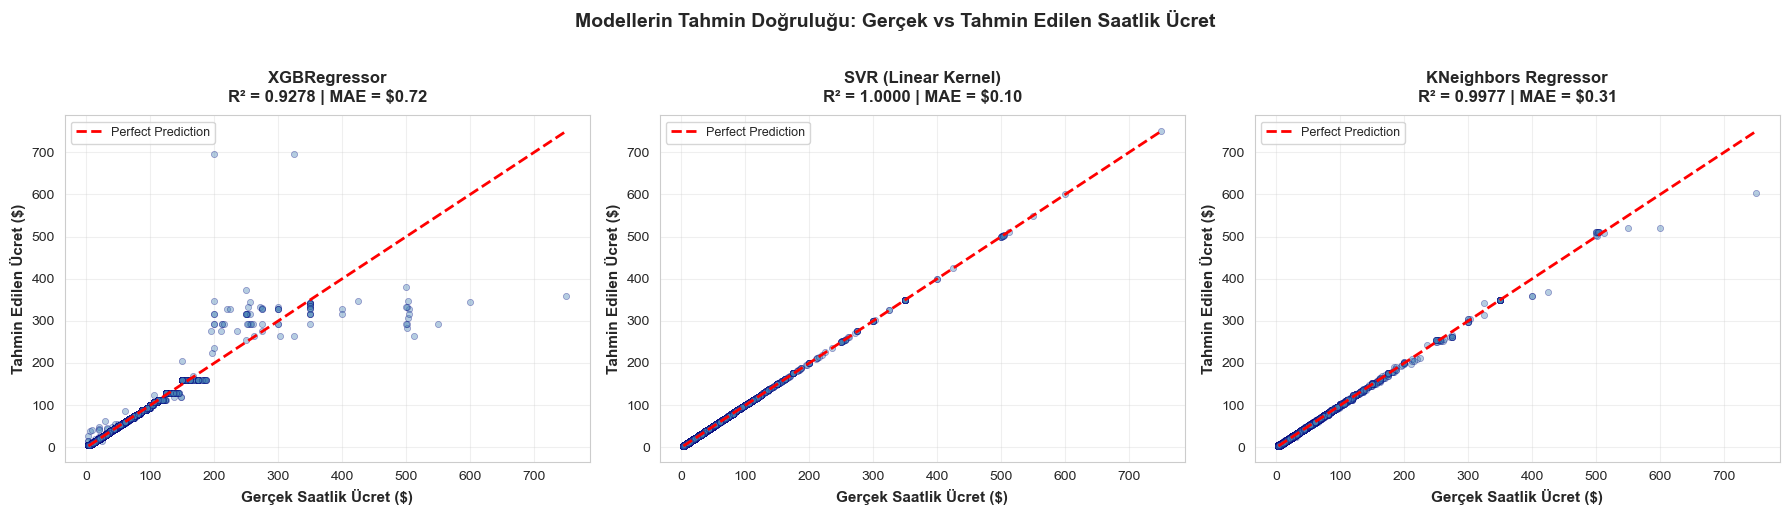

✓ asil_regression_metrics_heatmap.png kaydedildi.


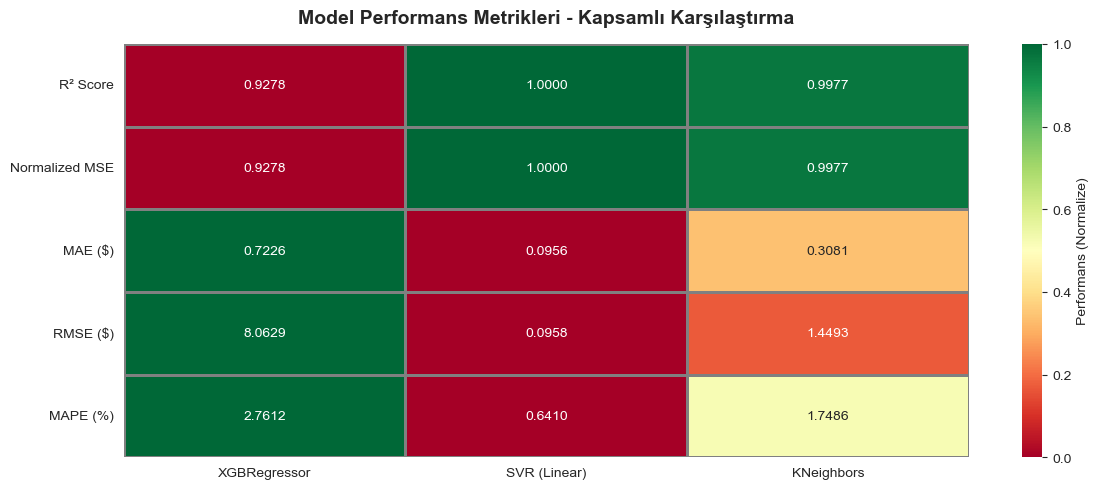


REGRESYON MODELLERİ PERFORMANS RANKING (ASIL)
       Model R² Score MAE ($) RMSE ($) MAPE (%)
XGBRegressor   0.9278    0.72     8.06     2.76
SVR (Linear)   1.0000    0.10     0.10     0.64
  KNeighbors   0.9977    0.31     1.45     1.75

✓ asil_regression_residuals_analysis.png kaydedildi.


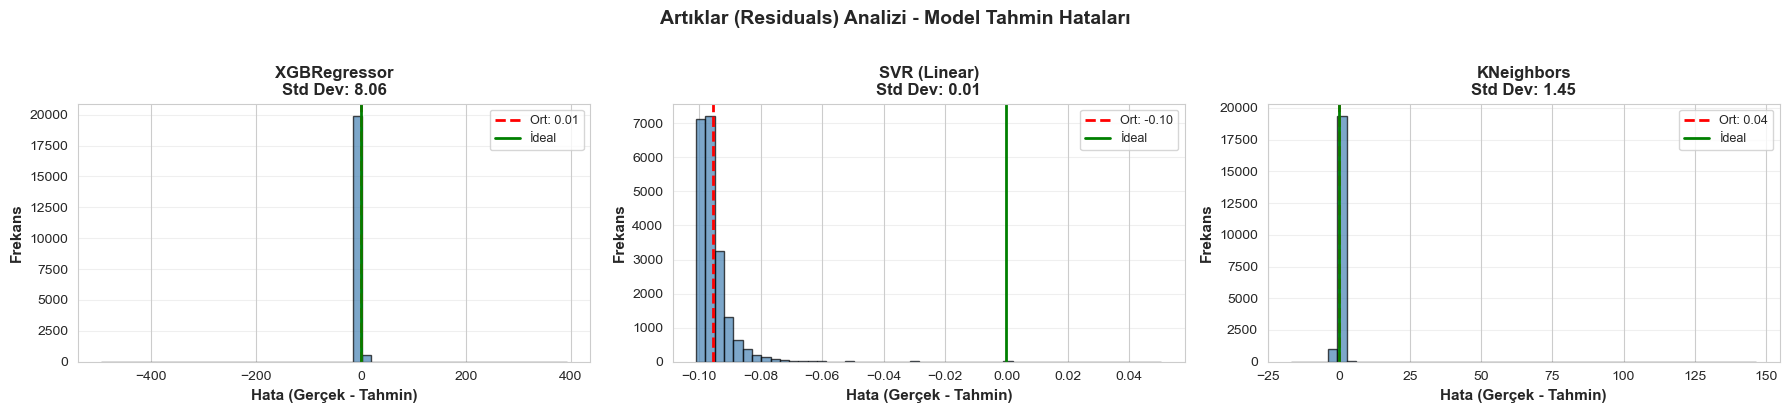

✓ asil_regression_r2_mae_comparison.png kaydedildi.


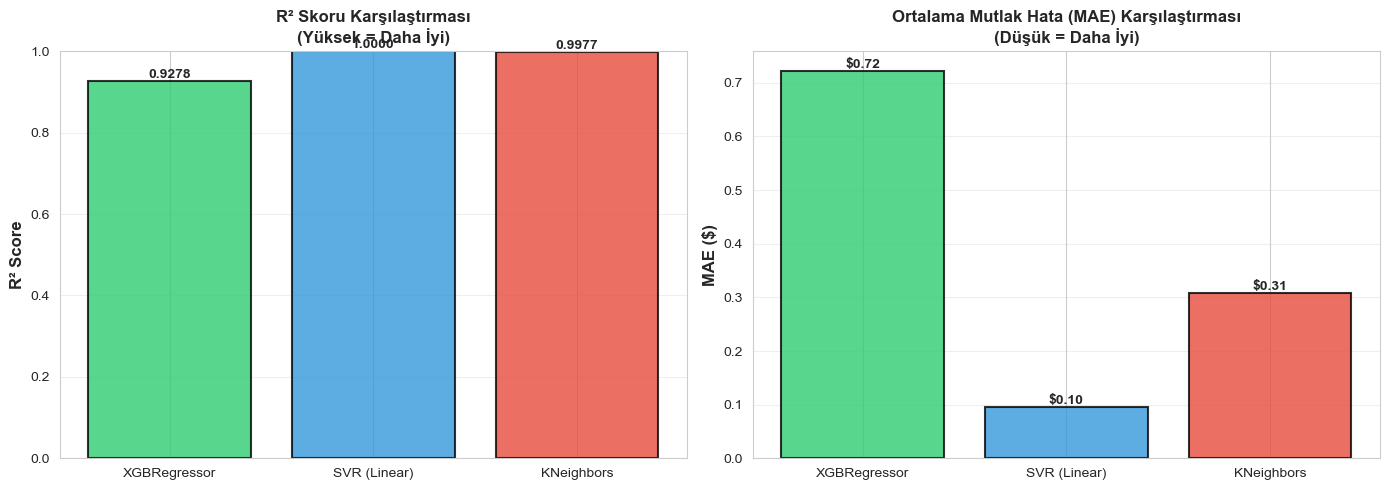


REGRESYON GÖRSELLERİ BAŞARIYLA OLUŞTURULDU (ASIL - TÜM MODELLER)


In [13]:
# =====================================================
# HÜCRE 7 – REGRESYON GÖRSELLERİ (تصميم عصري + مقارنات مفهومة)
# =====================================================
# Bu hücre:
# 1) XGBRegressor, SVR (linear) ve KNeighborsRegressor için 
#    Gerçek vs Tahmin Edilen Saatlik Ücret scatter plotlarını çizer
# 2) Modellerin R2, MAE, RMSE skorlarını side-by-side gösterir
# 3) Model performansını ranking tablosu ile gösterir
# 4) Residual dağılımlarını gösterir
# =====================================================

import seaborn as sns
sns.set_style("whitegrid")

# ===== 1. SCATTER PLOTS: GERÇEKvsTAHMİN =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Modellerin Tahmin Doğruluğu: Gerçek vs Tahmin Edilen Saatlik Ücret", 
             fontsize=14, fontweight="bold", y=1.02)

models_data = [
    (y_pred_xgbr, "XGBRegressor", axes[0]),
    (y_pred_svr,  "SVR (Linear Kernel)", axes[1]),
    (y_pred_knn,  "KNeighbors Regressor", axes[2]),
]

for y_pred, label, ax in models_data:
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Scatter plot with diagonal line
    ax.scatter(y_test, y_pred, alpha=0.4, s=20, color='steelblue', edgecolors='navy', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel("Gerçek Saatlik Ücret ($)", fontsize=11, fontweight='bold')
    ax.set_ylabel("Tahmin Edilen Ücret ($)", fontsize=11, fontweight='bold')
    ax.set_title(f"{label}\nR² = {r2:.4f} | MAE = ${mae:.2f}", 
                 fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig("asil_regression_scatter_comparison.png", dpi=300, bbox_inches="tight")
print("✓ asil_regression_scatter_comparison.png kaydedildi.")
plt.show()

# ===== 2. MULTI-METRIC COMPARISON (Heatmap Stili) =====
fig, ax = plt.subplots(figsize=(12, 5))

metrics_data = []
model_names = []

for y_pred, label in [
    (y_pred_xgbr, "XGBRegressor"),
    (y_pred_svr, "SVR (Linear)"),
    (y_pred_knn, "KNeighbors"),
]:
    r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred)
    metrics_data.append([r2, 1-(mse/y_test.var()), mae, rmse, mape])
    model_names.append(label)

# Normalize metrics for better visualization
metrics_array = np.array(metrics_data)
metrics_normalized = (metrics_array - metrics_array.min(axis=0)) / (metrics_array.max(axis=0) - metrics_array.min(axis=0))

sns.heatmap(
    metrics_normalized.T,
    annot=metrics_array.T,
    fmt='.4f',
    cmap='RdYlGn',
    cbar_kws={'label': 'Performans (Normalize)'},
    xticklabels=model_names,
    yticklabels=['R² Score', 'Normalized MSE', 'MAE ($)', 'RMSE ($)', 'MAPE (%)'],
    linewidths=1,
    linecolor='gray',
    ax=ax,
    vmin=0,
    vmax=1,
    cbar=True
)

ax.set_title("Model Performans Metrikleri - Kapsamlı Karşılaştırma", 
             fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig("asil_regression_metrics_heatmap.png", dpi=300, bbox_inches="tight")
print("✓ asil_regression_metrics_heatmap.png kaydedildi.")
plt.show()

# ===== 3. RANKING TABLOSU =====
ranking_data = []

for y_pred, label in [
    (y_pred_xgbr, "XGBRegressor"),
    (y_pred_svr, "SVR (Linear)"),
    (y_pred_knn, "KNeighbors"),
]:
    r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred)
    ranking_data.append({
        'Model': label,
        'R² Score': f"{r2:.4f}",
        'MAE ($)': f"{mae:.2f}",
        'RMSE ($)': f"{rmse:.2f}",
        'MAPE (%)': f"{mape:.2f}"
    })

ranking_df = pd.DataFrame(ranking_data)
print("\n" + "="*70)
print("REGRESYON MODELLERİ PERFORMANS RANKING (ASIL)")
print("="*70)
print(ranking_df.to_string(index=False))

# ===== 4. RESIDUAL ANALYSIS =====
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle("Artıklar (Residuals) Analizi - Model Tahmin Hataları", 
             fontsize=14, fontweight='bold', y=1.02)

for (y_pred, label, ax) in [
    (y_pred_xgbr, "XGBRegressor", axes[0]),
    (y_pred_svr, "SVR (Linear)", axes[1]),
    (y_pred_knn, "KNeighbors", axes[2]),
]:
    residuals = y_test - y_pred
    
    ax.hist(residuals, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Ort: {residuals.mean():.2f}')
    ax.axvline(0, color='green', linestyle='-', linewidth=2, label='İdeal')
    
    ax.set_xlabel("Hata (Gerçek - Tahmin)", fontsize=11, fontweight='bold')
    ax.set_ylabel("Frekans", fontsize=11, fontweight='bold')
    ax.set_title(f"{label}\nStd Dev: {residuals.std():.2f}", fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("asil_regression_residuals_analysis.png", dpi=300, bbox_inches="tight")
print("\n✓ asil_regression_residuals_analysis.png kaydedildi.")
plt.show()

# ===== 5. R2 & MAE SIDE-BY-SIDE COMPARISON =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

model_labels = ["XGBRegressor", "SVR (Linear)", "KNeighbors"]
r2_scores = [r2_score(y_test, y_pred_xgbr), 
             r2_score(y_test, y_pred_svr), 
             r2_score(y_test, y_pred_knn)]
mae_scores = [mean_absolute_error(y_test, y_pred_xgbr),
              mean_absolute_error(y_test, y_pred_svr),
              mean_absolute_error(y_test, y_pred_knn)]

colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red

# R2 Score
bars1 = ax1.bar(model_labels, r2_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel("R² Score", fontsize=12, fontweight='bold')
ax1.set_title("R² Skoru Karşılaştırması\n(Yüksek = Daha İyi)", fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)
for bar, score in zip(bars1, r2_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# MAE Score (Lower is Better)
bars2 = ax2.bar(model_labels, mae_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel("MAE ($)", fontsize=12, fontweight='bold')
ax2.set_title("Ortalama Mutlak Hata (MAE) Karşılaştırması\n(Düşük = Daha İyi)", fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, score in zip(bars2, mae_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${score:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig("asil_regression_r2_mae_comparison.png", dpi=300, bbox_inches="tight")
print("✓ asil_regression_r2_mae_comparison.png kaydedildi.")
plt.show()

print("\n" + "="*70)
print("REGRESYON GÖRSELLERİ BAŞARIYLA OLUŞTURULDU (ASIL - TÜM MODELLER)")
print("="*70)


In [9]:
# =====================================================
# HÜCRE 8 – PYTORCH VERİ HAZIRLAMA (REGRESYON)
# Bu hücre:
# 1) Seyrek (sparse) X_train ve X_test matrislerini dense hale getirir
# 2) StandardScaler ile ölçekler
# 3) PyTorch DataLoader nesnesi oluşturur
# 4) Kayıp fonksiyonu olarak MSELoss seçilir (regression için)
# =====================================================

print("\n" + "="*70)
print("PYTORCH DERİN ÖĞRENME REGRESYON MODELLERİ (ASIL)")
print("="*70)

# Seyrek matrisleri yoğun (dense) numpy dizisine çevir
X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense  = X_test.toarray().astype(np.float32)

# Hedef değişkeni numpy dizisine çevir
y_train_np = y_train.astype(np.float32)
y_test_np  = y_test.astype(np.float32)

# Özellikleri ölçekle (0 ortalama, 1 standart sapma)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled  = scaler.transform(X_test_dense)

# Cihaz seçimi (GPU varsa CUDA, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# PyTorch Dataset ve DataLoader
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train_np.reshape(-1, 1))
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,   # her iterasyonda 64 örnek
    shuffle=True
)

# Sonuçları saklamak için liste
pytorch_results = []

# Ortak kayıp fonksiyonu (MSE – Regression için)
loss_fn = nn.MSELoss()

print("PyTorch veri hazırlığı tamamlandı.")



PYTORCH DERİN ÖĞRENME REGRESYON MODELLERİ (ASIL)
Kullanılan cihaz: cpu
PyTorch veri hazırlığı tamamlandı.


In [10]:
# =====================================================
# HÜCRE 9 – MLP REGRESYON MODELİNİN EĞİTİLMESİ
# Bu hücre:
# 1) MLP tabanlı bir regresyon modeli tanımlar
# 2) 5 epoch boyunca eğitir
# 3) Test setinde MLP regresyon performansını hesaplar
# =====================================================

print("\n1) MLP Regresyon modeli eğitiliyor (5 epoch)...")

class MLPRegression(nn.Module):
    """
    Basit çok katmanlı algılayıcı (Multi Layer Perceptron) REGRESYON modeli.
    Giriş: TF-IDF + sayısal özellikler
    Çıkış: Gerçek değer (saatlik ücret tahmini)
    """
    def __init__(self, input_size):
        super(MLPRegression, self).__init__()
        self.fc1   = nn.Linear(input_size, 128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2   = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3   = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)  # Regression: Sigmoid yok
        return x

mlp_model = MLPRegression(X_train_scaled.shape[1]).to(device)
optim_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_model.train()
for epoch in range(5):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_mlp.zero_grad()
        out  = mlp_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_mlp.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp (MSE): {epoch_loss/len(train_loader):.4f}")

# Test seti üzerinde değerlendirme
mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = mlp_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()

r2, mse, rmse, mae, mape = regression_metrics(y_test_np, y_pred_mlp)

pytorch_results.append({
    "Model":        "MLP",
    "Architecture": "128-64-1",
    "R2":   r2,
    "MSE":  mse,
    "RMSE": rmse,
    "MAE":  mae,
    "MAPE": mape
})

print("MLP eğitimi tamamlandı.")



1) MLP Regresyon modeli eğitiliyor (5 epoch)...
Epoch 1/5 - Ortalama Kayıp (MSE): 369.4737
Epoch 2/5 - Ortalama Kayıp (MSE): 75.5545
Epoch 3/5 - Ortalama Kayıp (MSE): 57.8453
Epoch 4/5 - Ortalama Kayıp (MSE): 50.9925
Epoch 5/5 - Ortalama Kayıp (MSE): 44.3880
MLP eğitimi tamamlandı.


In [11]:
# =====================================================
# HÜCRE 10 – LSTM REGRESYON MODELİNİN EĞİTİLMESİ
# Bu hücre:
# 1) LSTM tabanlı bir regresyon modeli tanımlar
# 2) 5 epoch boyunca eğitir
# 3) Test setinde LSTM regresyon performansını hesaplar
# Not: Veri zamansal olmasa bile, ödev kapsamında LSTM kullanımı gösterilir.
# =====================================================

print("\n2) LSTM Regresyon modeli eğitiliyor (5 epoch)...")

class LSTMRegression(nn.Module):
    """
    LSTM tabanlı REGRESYON modeli.
    Giriş: (batch_size, features) -> (batch_size, 1, features)
    Çıkış: Gerçek değer (saatlik ücret tahmini)
    """
    def __init__(self, input_size):
        super(LSTMRegression, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            batch_first=True,
            num_layers=1
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Regression: Sigmoid yok
        )

    def forward(self, x):
        x = x.unsqueeze(1)             # (batch, features) -> (batch, 1, features)
        _, (h, _) = self.lstm(x)
        x = self.fc(h[-1])
        return x

lstm_model = LSTMRegression(X_train_scaled.shape[1]).to(device)
optim_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

lstm_model.train()
for epoch in range(5):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_lstm.zero_grad()
        out  = lstm_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_lstm.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp (MSE): {epoch_loss/len(train_loader):.4f}")

# Test seti değerlendirme
lstm_model.eval()
with torch.no_grad():
    y_pred_lstm = lstm_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()

r2, mse, rmse, mae, mape = regression_metrics(y_test_np, y_pred_lstm)

pytorch_results.append({
    "Model":        "LSTM",
    "Architecture": "LSTM(64)-32-1",
    "R2":   r2,
    "MSE":  mse,
    "RMSE": rmse,
    "MAE":  mae,
    "MAPE": mape
})

print("LSTM eğitimi tamamlandı.")

# PyTorch sonuçlarını tabloya dök
pytorch_df = pd.DataFrame(pytorch_results).round(4)
print("\nPYTORCH REGRESYON PERFORMANSI (ASIL)")
print(pytorch_df.to_string(index=False))

pytorch_df.to_csv("asil_pytorch_regression_models_fast_full.csv", index=False)
print("\nasil_pytorch_regression_models_fast_full.csv dosyası kaydedildi.")



2) LSTM Regresyon modeli eğitiliyor (5 epoch)...
Epoch 1/5 - Ortalama Kayıp (MSE): 833.8589
Epoch 2/5 - Ortalama Kayıp (MSE): 258.3972
Epoch 3/5 - Ortalama Kayıp (MSE): 149.3725
Epoch 4/5 - Ortalama Kayıp (MSE): 101.9279
Epoch 5/5 - Ortalama Kayıp (MSE): 76.5384
LSTM eğitimi tamamlandı.

PYTORCH REGRESYON PERFORMANSI (ASIL)
Model  Architecture     R2      MSE    RMSE    MAE    MAPE
  MLP      128-64-1 0.9758  21.7540  4.6641 3.1998 19.5725
 LSTM LSTM(64)-32-1 0.8050 175.5212 13.2484 5.7688 30.4904

asil_pytorch_regression_models_fast_full.csv dosyası kaydedildi.
